# Score Comparison
This notebook compares scaffold promiscuity scores (pscores) between badapple_classic and badapple2 DBs.

Note that scaffolds which have a score of 'None' are marked with a score of -1.0. If a given scaffold has a score of 'None' in **both** DBs then it is dropped before calculating metrics, otherwise it is kept.

## Setup

In [ ]:
# define DB variables
ORIGINAL_DB_NAME = "badapple_classic"
ORIGINAL_DB_HOST = "localhost"
ORIGINAL_DB_USER = "<your_user>"
ORIGINAL_DB_PASSWORD = "<your_password>"

COMPARISON_DB_NAME = "badapple2"
COMPARISON_DB_HOST = ORIGINAL_DB_HOST
COMPARISON_DB_USER = ORIGINAL_DB_USER
COMPARISON_DB_PASSWORD = ORIGINAL_DB_PASSWORD

In [2]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from rdkit import Chem
import numpy as np

## Connect to DBs

In [3]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [4]:
original_db_connection = db_connect(ORIGINAL_DB_NAME, ORIGINAL_DB_HOST, ORIGINAL_DB_USER, ORIGINAL_DB_PASSWORD)
comparison_db_connection = db_connect(COMPARISON_DB_NAME, COMPARISON_DB_HOST, COMPARISON_DB_USER, COMPARISON_DB_PASSWORD)

In [5]:
original_db_cur = original_db_connection.cursor()
comparison_db_cur = comparison_db_connection.cursor()

## View metadata
Medians/overall stats

In [6]:
def get_summary_stats(db_cursor, db_conn):
    query = sql.SQL("SELECT median_ncpd_tested,median_nsub_tested,median_nass_tested,median_nsam_tested,nass_total FROM metadata")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result[0] # only 1 row
    except Exception:
        db_conn.rollback()
    return result

In [7]:
original_stats = get_summary_stats(original_db_cur, original_db_connection)
comparison_stats = get_summary_stats(comparison_db_cur, comparison_db_connection)

In [8]:
stat_diff = list(np.array(comparison_stats) - np.array(original_stats))
columns = ["source","median_ncpd_tested","median_nsub_tested","median_nass_tested","median_nsam_tested","nass_total"]
rows = [["badapple_classsic"] + original_stats, ["badapple2"] + comparison_stats, ["diff"] + stat_diff]
summary_df = pd.DataFrame(rows, columns=columns)

In [9]:
summary_df

,source,median_ncpd_tested,median_nsub_tested,median_nass_tested,median_nsam_tested,nass_total
0,badapple_classsic,2,2,633,773,823
1,badapple2,1,2,8,11,906
2,diff,-1,0,-625,-762,83


## Get pscores of shared scaffolds

In [10]:
def get_pscores(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pscore FROM scaffold order by scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [11]:
original_pscores = get_pscores(original_db_cur, original_db_connection)
comparison_pscores = get_pscores(comparison_db_cur, comparison_db_connection)

In [12]:
def get_pscore_df(pscore_list: list[list[str, int]]):
    df = pd.DataFrame(pscore_list, columns=['scafsmi', 'pscore'])
    # some compounds have 'None' as pscore (no evidence)
    # don't drop here in case this scaffold has a different score in other DB
    df['pscore'] = df['pscore'].fillna(-1.0) 
    return df

In [13]:
original_df = get_pscore_df(original_pscores)
comparison_df = get_pscore_df(comparison_pscores)

In [14]:
# get df containing shared scaffolds
shared_df = pd.merge(original_df, comparison_df, on='scafsmi')
shared_df.rename(columns={"pscore_x": "pscore_classic", "pscore_y": "pscore_2"}, inplace=True)

# drop entries where both pscores were None
# currently not relevant since there are 0 "None" scores in badapple2
shared_df = shared_df[~((shared_df['pscore_classic'] < 0) & (shared_df['pscore_2'] < 0))]

In [15]:
shared_df

,scafsmi,pscore_classic,pscore_2
0,B1OCCO1,-1.0,0.0
1,[BH2-](c1ccccc1)c1ccccc1,10.0,3.0
2,C1C2C1C1C3CC4C(C23)C41,0.0,0.0
3,C1C2C3C4OC5C3C1C1C2C4C51,0.0,0.0
4,C1C2C3CC4C5CC(C1C35)C24,4.0,2.0
...,...,...,...
142877,S=P(NCCNP(=S)(N1CC1)N1CC1)(N1CC1)N1CC1,0.0,0.0
142878,S=P(NCCSCc1ccccc1)(N1CC1)N1CC1,1.0,1.0
142879,S=P(N=CN1CCOCC1)(N1CCOCC1)N1CCOCC1,0.0,0.0
142880,S=P(Nn1cnnc1)(c1ccccc1)c1ccccc1,0.0,0.0


## Calculate correlation, visualize with parity plot

In [16]:
def create_parity_plot(df: pd.DataFrame, x_col: str, y_col: str, title: str=None):
    plt.style.use('ggplot')
    plt.scatter(df[x_col], df[y_col], alpha=0.5)
    # Create parity line
    plt.plot(df[x_col], df[x_col], color='black')
    ax = plt.gca()
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()

In [17]:
# use scipy to calculate correlation + pval
correlation, p_value = pearsonr(shared_df["pscore_classic"], shared_df["pscore_2"])

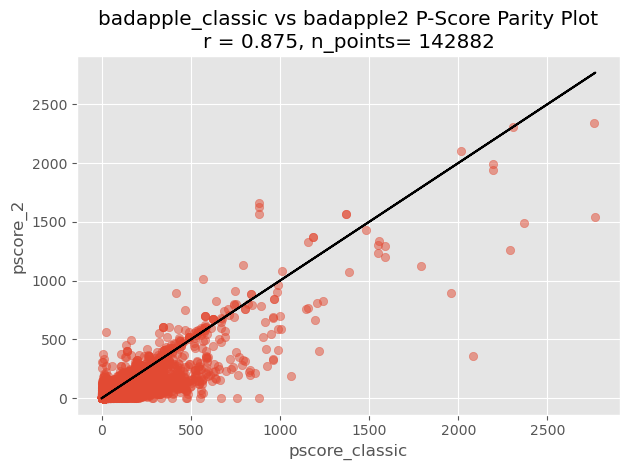

In [18]:
# visualize parity plot (with 'None' entries included)
plot_title = "badapple_classic vs badapple2 P-Score Parity Plot\nr = %.3f, n_points= %d" % (correlation, len(shared_df))
create_parity_plot(shared_df, "pscore_classic", "pscore_2", plot_title)
plt.show()

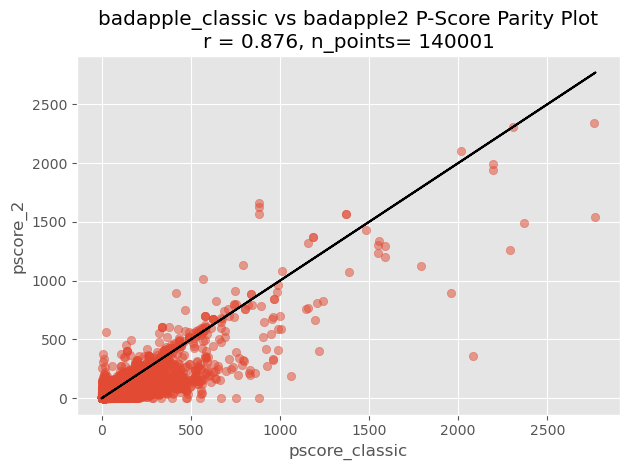

In [19]:
# parity plot (without 'None' entries from badapple_classic included)
shared_df_no_nan = shared_df[~(shared_df['pscore_classic'] < 0)]
correlation, p_value = pearsonr(shared_df_no_nan["pscore_classic"], shared_df_no_nan["pscore_2"])
plot_title = "badapple_classic vs badapple2 P-Score Parity Plot\nr = %.3f, n_points= %d" % (correlation, len(shared_df_no_nan))
create_parity_plot(shared_df_no_nan, "pscore_classic", "pscore_2", plot_title)
plt.show()

## Compare pscore rankings

In [20]:
shared_df_no_nan["classic_rank"] = shared_df_no_nan["pscore_classic"].rank()
shared_df_no_nan["2_rank"] = shared_df_no_nan["pscore_2"].rank()

/tmp/ipykernel_229917/138781182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["classic_rank"] = shared_df_no_nan["pscore_classic"].rank()
/tmp/ipykernel_229917/138781182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["2_rank"] = shared_df_no_nan["pscore_2"].rank()


In [21]:
shared_df_no_nan["rank_diff"] = shared_df_no_nan["classic_rank"] - shared_df_no_nan["2_rank"]

/tmp/ipykernel_229917/3954084723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["rank_diff"] = shared_df_no_nan["classic_rank"] - shared_df_no_nan["2_rank"]


In [22]:
def plot_rank_histogram():
    plt.hist(shared_df_no_nan["rank_diff"], bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('pscore_rank_diff')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Rank differences:\n(badapple_classic rank) - (badapple2 rank)')
    plt.show()

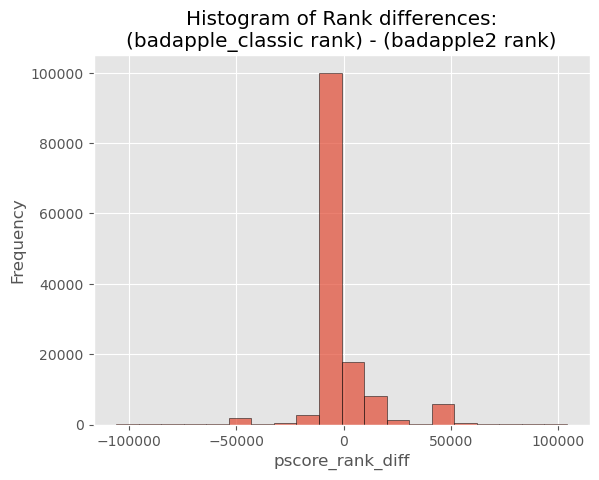

In [23]:
plot_rank_histogram()

## Compare non-normalized (NN) scores
This comparison is motivated by the difference in median statistics above

In [24]:
SCAF_COL_STR = "scafsmi,nsub_tested,nsub_active,nass_tested,nass_active,nsam_tested,nsam_active"
SCAF_COL_LIST = SCAF_COL_STR.split(",")

In [25]:
def compute_pscore_nn(
    row
) -> float:
    sTested = row["nsub_tested"]
    sActive = row["nsub_active"]
    aTested = row["nass_tested"]
    aActive = row["nass_active"]
    wTested = row["nsam_tested"]
    wActive = row["nsam_active"]
    if sTested == 0 or aTested == 0 or wTested == 0:
        return None  # None means no evidence

    pScore_nn = (
        1.0
        * sActive
        / (sTested)
        * aActive
        / (aTested)
        * wActive
        / (wTested)
    ) * 1e5
    pScore_nn = round(pScore_nn, 0)  
    return pScore_nn

In [26]:
def get_scaf_stats(db_cursor, db_conn):
    query = sql.SQL(f"SELECT {SCAF_COL_STR} FROM scaffold order by scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception as e:
        print(e)
        db_conn.rollback()
    return result

In [27]:
def get_pscore_nn_df(pscore_list: list[list[str, int]]):
    df = pd.DataFrame(pscore_list, columns=SCAF_COL_LIST)
    df["pscore_nn"] = df.apply(compute_pscore_nn, axis=1)
    df.dropna(subset="pscore_nn", inplace=True)
    return df

In [28]:
original_scaf_stats = get_scaf_stats(original_db_cur, original_db_connection)
comparison_scaf_stats = get_scaf_stats(comparison_db_cur, comparison_db_connection)

In [29]:
original_df_nn = get_pscore_nn_df(original_scaf_stats)
comparison_df_nn = get_pscore_nn_df(comparison_scaf_stats)

In [30]:
# remove stats
original_df_nn = original_df_nn[["scafsmi", "pscore_nn"]]
comparison_df_nn = comparison_df_nn[["scafsmi", "pscore_nn"]]

In [31]:
# get df containing shared scaffolds
shared_df_nn = pd.merge(original_df_nn, comparison_df_nn, on='scafsmi')
shared_df_nn.rename(columns={"pscore_nn_x": "pscore_nn_classic", "pscore_nn_y": "pscore_nn_2"}, inplace=True)

# drop entries where both pscores were None
# currently not relevant since there are 0 "None" scores in badapple2
shared_df_nn = shared_df_nn[~((shared_df_nn['pscore_nn_classic'] < 0) & (shared_df_nn['pscore_nn_2'] < 0))]

In [32]:
# use scipy to calculate correlation + pval
correlation_nn, p_value_nn = pearsonr(shared_df_nn["pscore_nn_classic"], shared_df_nn["pscore_nn_2"])

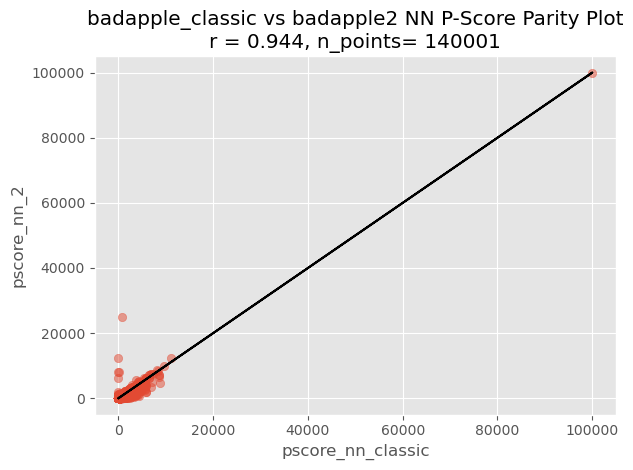

In [33]:
# visualize parity plot
plot_title = "badapple_classic vs badapple2 NN P-Score Parity Plot\nr = %.3f, n_points= %d" % (correlation_nn, len(shared_df_nn))
create_parity_plot(shared_df_nn, "pscore_nn_classic", "pscore_nn_2", plot_title)
plt.show()

## Score histograms

In [34]:
def show_score_histogram(pscore_values: pd.Series, db_source: str):
    # Define the ranges and corresponding colors
    ranges = [(-float('inf'), 0), (0, 100), (100, 300), (300, float('inf'))]
    colors = ['grey', 'green', 'yellow', 'red']
    labels = ['pscore = ~', '0 <= pscore < 100', '100 <= pscore < 300', 'pscore >= 300']

    # Create lists to hold the pscore values for each range
    pscore_lists = [[] for _ in ranges]
    counts = [0] * len(ranges)

    # Distribute the pscore values into the corresponding lists
    for pscore in pscore_values:
        for i, (low, high) in enumerate(ranges):
            if low <= pscore < high:
                pscore_lists[i].append(pscore)
                counts[i] += 1
                break
    
    # Define the bin edges in increments of 25
    bin_size = 25
    # min score is 0
    bin_edges = np.arange(-bin_size, max(pscore_values) + bin_size, bin_size)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    for pscore_list, color in zip(pscore_lists, colors):
        plt.hist(pscore_list, bins=bin_edges, color=color, edgecolor='black', alpha=0.7)

    plt.xlabel('pscore')
    plt.ylabel('Frequency')
    plt.yscale("log")
    plt.title(f'Histogram of P-Score Values from {db_source}\nBin Size={bin_size}')

    total_count = len(pscore_values)
    pct = lambda count : "%.2f" % ((100 * count) / total_count)
    legend_labels = [f'{label} : {count} ({pct(count)}%)' for label, count in zip(labels, counts)]
    legend_title = f"Counts (Total={total_count})"
    plt.legend(legend_labels, title=legend_title, loc='upper right')

    plt.show()

### Original DB (badapple_classic)

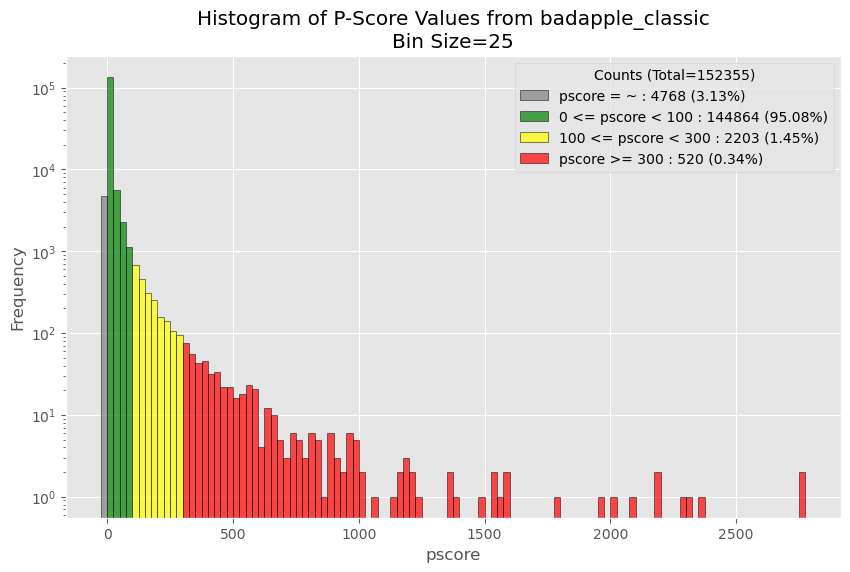

In [35]:
show_score_histogram(original_df["pscore"], "badapple_classic")

### New DB (badapple2)

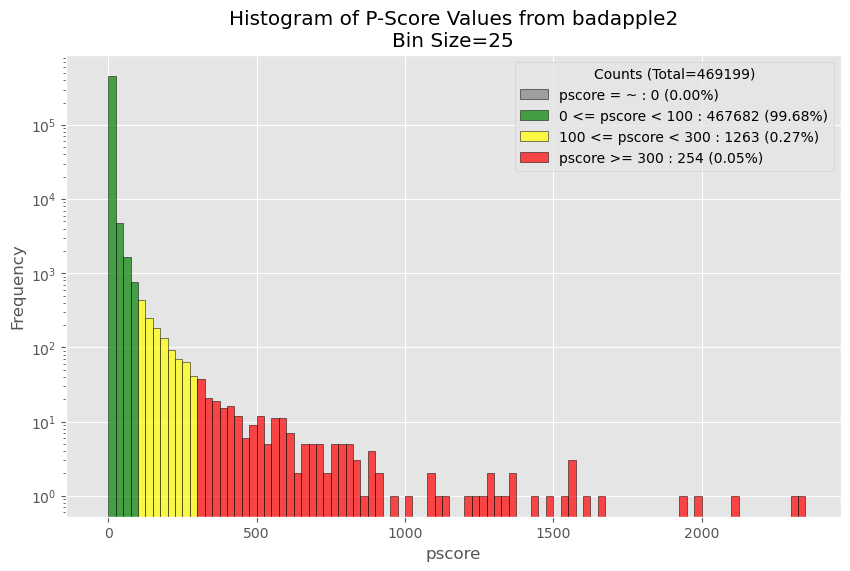

In [36]:
show_score_histogram(comparison_df["pscore"], "badapple2")

## Compare "InDrug" Scores
This section compares the scores for scaffolds which were found to be present in approved drugs from [DrugCentral](https://drugcentral.org/).

### Get pscores of indrug scaffolds

In [37]:
def get_pscores_ind(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pscore FROM scaffold WHERE in_drug ORDER BY scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [38]:
original_pscores_ind = get_pscores_ind(original_db_cur, original_db_connection)
comparison_pscores_ind = get_pscores_ind(comparison_db_cur, comparison_db_connection)

In [39]:
original_df_ind = get_pscore_df(original_pscores_ind)
comparison_df_ind = get_pscore_df(comparison_pscores_ind)

In [40]:
# get df containing shared scaffolds
shared_df_ind = pd.merge(original_df_ind, comparison_df_ind, on='scafsmi')
shared_df_ind.rename(columns={"pscore_x": "pscore_classic", "pscore_y": "pscore_2"}, inplace=True)

# drop entries where both pscores were None
shared_df_ind = shared_df_ind[~((shared_df_ind['pscore_classic'] < 0) & (shared_df['pscore_2'] < 0))]

/tmp/ipykernel_229917/2706409221.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shared_df_ind = shared_df_ind[~((shared_df_ind['pscore_classic'] < 0) & (shared_df['pscore_2'] < 0))]


In [41]:
shared_df_ind

,scafsmi,pscore_classic,pscore_2
0,C1=C2c3cccc4[nH]cc(c34)CC2NCC1,280.0,186.0
1,C1C2CC3CC1CC(C2)C3,229.0,56.0
2,c1c2c(cc3c1OCO3)CCCC2,1.0,0.0
3,c1c2c(cc3c1OCO3)CNCC2,2.0,2.0
4,C1=C2CCC3C4CCCC4CCC3C2Cc2cnoc21,3.0,3.0
...,...,...,...
2222,S=C(Nc1ccccc1)Oc1ccc2ccccc2c1,1.0,0.0
2223,S=C(Nc1ccccn1)Oc1ccc2c(c1)CCCC2,-1.0,0.0
2224,S=C(Nc1ccc(Nc2ccccc2)cc1)N1CCNCC1,0.0,0.0
2225,S=[PH](N1CC1)N1CC1,10.0,7.0


### Parity Plot for shared indrug scafs

In [42]:
# use scipy to calculate correlation + pval
correlation_ind, p_value_ind = pearsonr(shared_df_ind["pscore_classic"], shared_df_ind["pscore_2"])

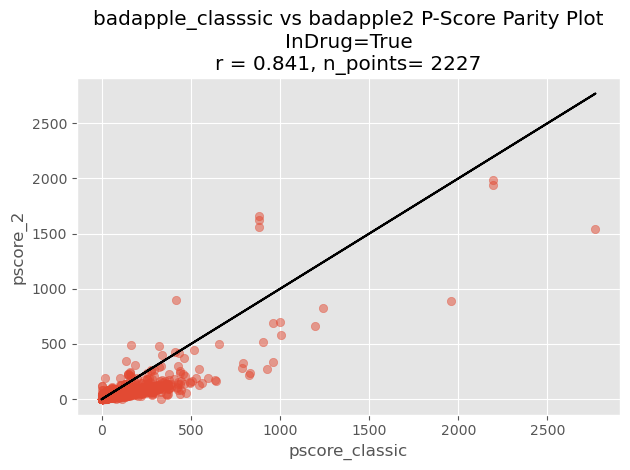

In [43]:
# visualize parity plot
plot_title = "badapple_classsic vs badapple2 P-Score Parity Plot\nInDrug=True\nr = %.3f, n_points= %d" % (correlation_ind, len(shared_df_ind))
create_parity_plot(shared_df_ind, "pscore_classic", "pscore_2", plot_title)
plt.show()

### Histogram of scores

#### Original DB (badapple_classic)

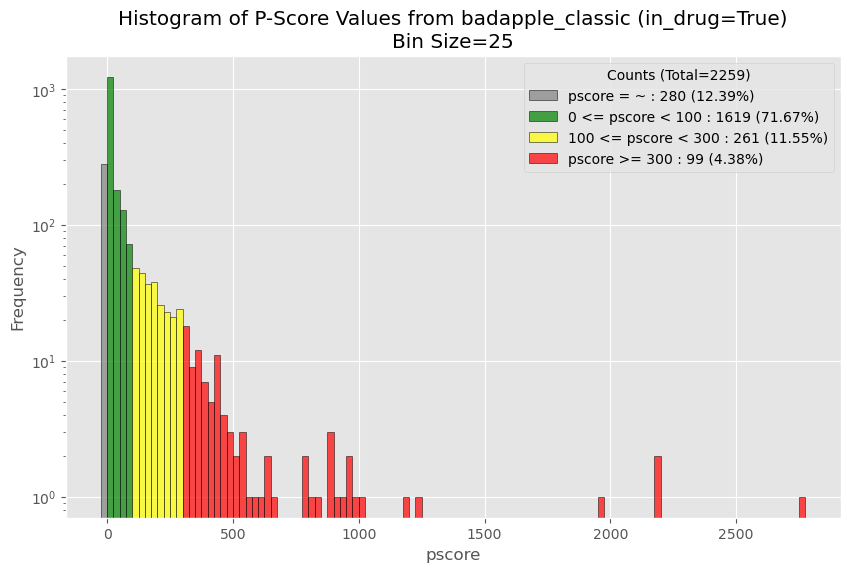

In [44]:
show_score_histogram(original_df_ind["pscore"], "badapple_classic (in_drug=True)")

#### New DB (badapple2)

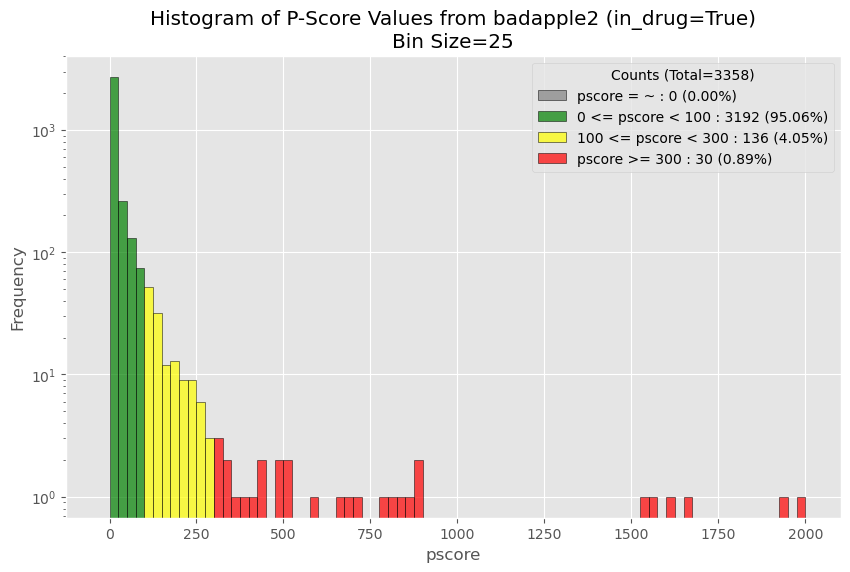

In [45]:
show_score_histogram(comparison_df_ind["pscore"], "badapple2 (in_drug=True)")

## Close DB connections

In [46]:
# Close the cursors
original_db_cur.close()
comparison_db_cur.close()

# Close the connections
original_db_connection.close()
comparison_db_connection.close()